# Wealth transfer

This is a demonstration on how to create a simple agent-based model with the [agentpy](https://agentpy.readthedocs.io) package. 
It shows how to create a custom agent and model class, run a model, and visualize output data.

The model explores the distribution of wealth under a trading population of agents. We will see that their random interaction will create an inequality of wealth that follows a [Boltzmann distribution](http://www.phys.ufl.edu/~meisel/Boltzmann.pdf).

The original version of this model been written in [MESA](https://mesa.readthedocs.io/) (Project Mesa Team, 2016), and can be found [here](https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html). This adaption of the same model for agentpy is meant to provide a comparison between the two frameworks.

In [1]:
import agentpy as ap
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class wealth_agent(ap.Agent):

    """ An agent with wealth """

    def setup(self):

        self.wealth = 1

    def wealth_transfer(self):

        if self.wealth > 0:

            partner = self.model.agents.random()
            partner.wealth += 1
            self.wealth -= 1

In [3]:
def gini(x):

    """ Calculate Gini Coefficient """
    # By Warren Weckesser https://stackoverflow.com/a/39513799

    mad = np.abs(np.subtract.outer(x, x)).mean()  # Mean absolute difference
    rmad = mad / np.mean(x)  # Relative mean absolute difference
    return 0.5 * rmad 

In [4]:
class wealth_model(ap.Model):

    """ A simple model of random wealth transfers """

    def setup(self):

        self.add_agents(self.p.agents, wealth_agent)

    def step(self):

        self.agents.wealth_transfer()

    def update(self):

        self.record('Gini Coefficient', gini(self.agents.wealth))

    def end(self):

        self.agents.record('wealth')

In [5]:
parameters = {
    'agents': 100,
    'steps': 100
}

In [6]:
model = wealth_model(parameters)
results = model.run()

Completed: 100 steps
Run time: 0:00:00.195641
Simulation finished


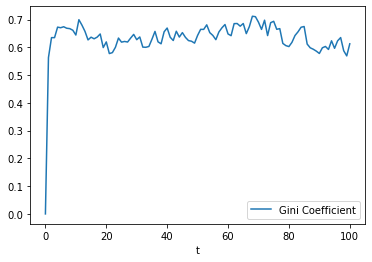

In [7]:
data = results.variables.model
ax = data.plot()

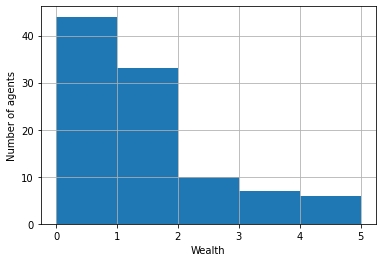

In [8]:
data = results.variables.wealth_agent
data.hist(bins=range(data.wealth.max()+1))

plt.title('')
plt.xlabel('Wealth')
plt.ylabel('Number of agents')
plt.show()

What we get is a Boltzmann distribution. For those interested to understand this result, you can read more about it [here](http://www.phys.ufl.edu/~meisel/Boltzmann.pdf).

## References

Project Mesa Team (2016). Introductory Tutorial (Revision 25205080). Retrieved from https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html